# Importing libraries (for image reading and displaying)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = "gray"
%matplotlib inline

# Helper Functions

In [2]:
# function to convert the RGB image to a gray scale
def RGB2GRAY(image):
    RED, GREEN, BLUE = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    output = 0.299 * RED + 0.587 * BLUE + 0.114 * GREEN
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = int(round(output[i, j]))
    
    return output


# function to pad zeros around the image
def pad_zeros(image, num_zeros):
    # num_zeros: the number of zeros to be padded at the border
    new_image = np.zeros((image.shape[0] + 2 * num_zeros, image.shape[1] + 2 * num_zeros))
    new_image[num_zeros:-num_zeros, num_zeros:-num_zeros] = image
    return new_image


# function to apply a computed filter on an image
def convolve(image, filter_):
    filter_size = filter_.shape[0] # assuming square filter
    zeros_padded = filter_size // 2
    temp_image = pad_zeros(image, zeros_padded) # pad zeros
    output_image = np.zeros(image.shape)
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            portion = temp_image[i:i + filter_.shape[0], j:j + filter_.shape[1]]
            output_image[i, j] = (portion * filter_).sum().sum()
    
    return output_image


invertDict = lambda dict_: {val: key for key, val in dict_.items()}

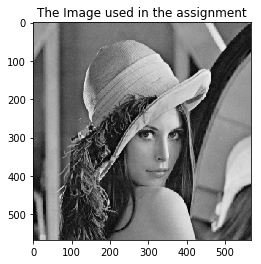

In [3]:
# reading the image and converting it to a grayscale image
lena_img = RGB2GRAY(np.copy(plt.imread("Lena.png") * 255))
_ = plt.imshow(lena_img)
_ = plt.title("The Image used in the assignment")

# 1. Weiner Filter

In [4]:
# function to apply wiener filter on an image
def wiener(im, mysize=None, noise=None):
    from scipy.signal import correlate
    im = np.asarray(im)
    if mysize is None:
        mysize = [20] * len(im.shape)
    mysize = np.asarray(mysize)
    if mysize.shape == ():
        mysize = np.repeat(mysize.item(), im.ndim)

    # Estimate the local mean
    lMean = correlate(im, np.ones(mysize), 'same') / np.product(mysize, axis=0)

    # Estimate the local variance
    lVar = (correlate(im ** 2, np.ones(mysize), 'same') / np.product(mysize, axis=0)
            - lMean ** 2)

    # Estimate the noise power if needed.
    if noise is None:
        noise = np.mean(np.ravel(lVar), axis=0)

    res = (im - lMean)
    res *= (1 - noise / lVar)
    res += lMean
    out = np.where(lVar < noise, lMean, res)

    return out

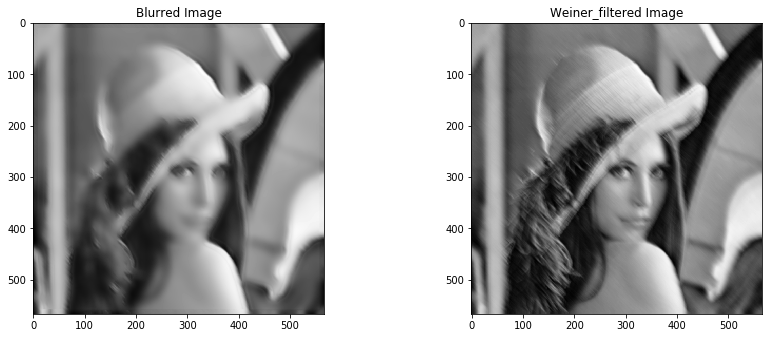

In [5]:
lena_blurred = plt.imread("lena_blurred.png") * 255
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].set_title("Blurred Image")
ax[0].imshow(wiener(lena_blurred))
ax[1].set_title("Weiner_filtered Image")
ax[1].imshow(lena_blurred)
plt.tight_layout()

# 2. Bilateral Filter

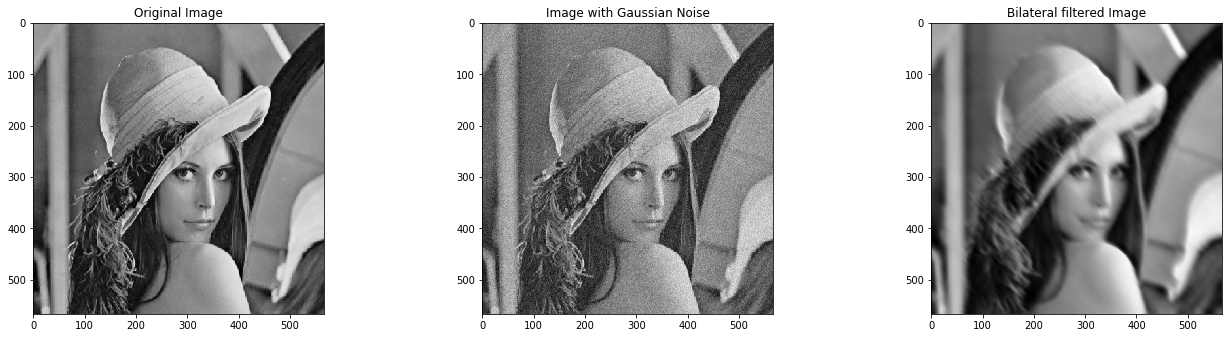

In [6]:
def addGaussianNoise(image, mean=0, sigma=15):
    gauss_noise = np.random.normal(mean, sigma, image.shape).reshape(*image.shape)
    return image + gauss_noise


def bilateral_filter(image, window=3, sigma_s=5, sigma_r=5):
    x = np.arange(-window, window)
    y = np.arange(-window, window)
    
    xx, yy = np.meshgrid(x, y)
    domain_filter = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma_s ** 2))
    
    
    output = np.zeros(image.shape)
    
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            imin, imax = max(i - window, 0), min(i + window, output.shape[0] - 1)
            jmin, jmax = max(j - window, 0), min(j + window, output.shape[1] - 1)
            
            temp_noisy = image[imin:imax, jmin:jmax]
            
            range_filter = np.exp(-(temp_noisy - image[i, j]) / (2 * sigma_r ** 2))
            slice1_start, slice1_end = min(np.arange(imin, imax) - i + window), max(np.arange(imin, imax) - i + window)
            slice2_start, slice2_end = min(np.arange(jmin, jmax) - j + window), max(np.arange(jmin, jmax) - j + window)
            bilateral = range_filter * domain_filter[slice1_start:slice1_end + 1, slice2_start:slice2_end + 1]
            fnorm = bilateral.flatten().sum()
            
            output[i, j] = (bilateral * temp_noisy).flatten().sum() / fnorm
    
    return output


noisy_image = addGaussianNoise(lena_img)
fig, ax = plt.subplots(1, 3, figsize=(6.4 * 3, 4.8))
ax[0].imshow(lena_img)
ax[0].set_title("Original Image")
ax[1].imshow(noisy_image)
ax[1].set_title("Image with Gaussian Noise")
ax[2].imshow(bilateral_filter(lena_blurred))
ax[2].set_title("Bilateral filtered Image")
plt.tight_layout()

# 3. Modified Huffman Coding

### Helper classes for Modified Huffman coding

In [7]:
class Node:
    def __init__(self, freq, left=None, right=None):
        self.freq = freq


class Internal(Node):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __repr__(self):
        return f"<Internal ({self.freq})>"
    
    def __str__(self):
        return f"<Internal ({self.freq})>"


class Leaf(Node):
    def __init__(self, intensity, *args, code=None, **kwargs):
        self.intensity = intensity
        super().__init__(*args, **kwargs)
    
    def __repr__(self):
        return f"<Leaf ({self.intensity}, {self.freq})>"
    
    def __str__(self):
        return f"<Leaf ({self.intensity}, {self.freq})>"

### Helper functions for Modified Huffman Coding

In [8]:
# return the counts of various pixel intensities in the image
def get_counts(image):
    return sorted(list(zip(*np.unique(image.flatten(), return_counts=True))), key=lambda x: x[1])


# make the huffman tree
def huffmanTree(counts):
    nodes = [Leaf(n[0], n[1]) for n in counts]

    # making the huffman tree
    while len(nodes) >= 2:
        leaf_0 = nodes.pop(0)
        leaf_1 = nodes.pop(0)
        
        new_node = Internal(freq=leaf_0.freq + leaf_1.freq)
        new_node.left = leaf_0
        new_node.right = leaf_1
        
        nodes.insert(0, new_node)
        nodes.sort(key=lambda x: x.freq)
    
    return nodes[0]


# assign the huffman codes to the pixel intensities
def makeHuffmanCodes(huffman_root, code):
    if type(huffman_root) == Leaf:
        huffman_root.code = code
    else:
        huffman_root.left = makeHuffmanCodes(huffman_root.left, code + "0")
        huffman_root.right = makeHuffmanCodes(huffman_root.right, code + "1")
    return huffman_root


# collect huffman codes in a list
def collectHuffmanCodes(huffman_root):
    if type(huffman_root) == Leaf:
        yield (huffman_root.intensity, huffman_root.code)
    else:
        yield from collectHuffmanCodes(huffman_root.left)
        yield from collectHuffmanCodes(huffman_root.right)


# apply the mapping on each row in the image
def modified_huffman_coding(image):
    output = []
    maps = []
    for row in range(image.shape[0]):
        huffman_codes = dict(collectHuffmanCodes(makeHuffmanCodes(huffmanTree(get_counts(image[row, :])), "")))
        maps.append(huffman_codes)
        temp = ""
        for val in image[row, :]:
            temp += huffman_codes[val]
        output.append(temp)
    return output, maps


# decompress the encoded image
def decompress_huffman_coding(compressed, maps, size):
    from time import sleep
    inverse_maps = list(map(invertDict, maps))
    output = np.zeros(size)
    assert len(compressed) == len(maps)
    
    for row_id in range(len(compressed)):
        row = compressed[row_id]
        start_id = 0
        offset = 1
        col = 0
        while start_id < len(row):
            try:
                temp_out = inverse_maps[row_id][row[start_id: start_id + offset]]
                output[row_id, col] = temp_out
                start_id += offset
                offset = 1
                col += 1
            except:
                offset += 1
    
    return output

#### Compressing the image using Huffman coding and comparing the size of the original with that of the compressed

In [9]:
from sys import getsizeof
print(f"Size of Original Image: {getsizeof(lena_img)}")
compressed, huffman_maps = modified_huffman_coding(lena_img)
print(f"Size of Compressed Image: {getsizeof(compressed)}")
print(f"Compression Ratio: {getsizeof(lena_img) / getsizeof(compressed)}")
print(f"Relative Data Redundacy: {1 - (getsizeof(compressed) / getsizeof(lena_img))}")

Size of Original Image: 1286068
Size of Compressed Image: 4848
Compression Ratio: 265.27805280528054
Relative Data Redundacy: 0.996230370400321


#### Decompressing the image

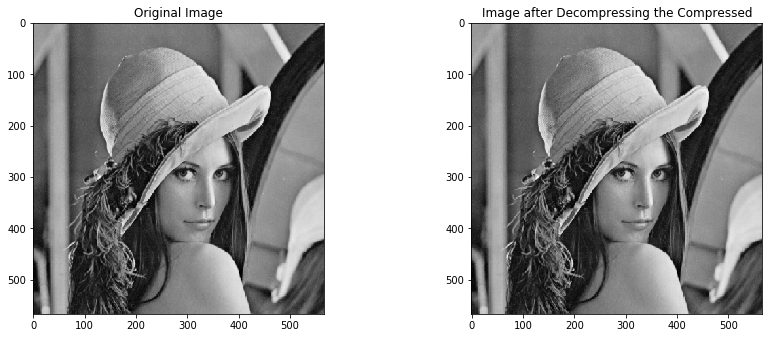

In [10]:
decompressed = decompress_huffman_coding(compressed, huffman_maps, lena_img.shape)
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].imshow(lena_img)
ax[0].set_title("Original Image")
ax[1].imshow(decompressed)
ax[1].set_title("Image after Decompressing the Compressed")
plt.tight_layout()

# 4. Histogram Equalization

In [11]:
# function to equalize the histogram of the image
def equalize_hist(image, L):
    from functools import reduce
    num_pixels = reduce(lambda x, y: x * y, image.shape)
    # 1. Get probability distribution
    dist = dict(zip(*np.unique(image, return_counts=True)))
    full_dist = [0] * L
    for i in range(L):
        try:
            full_dist[i] = dist[i] / num_pixels
        except:
            pass
    # 2. Get CDF
    # 3. Multiply by L - 1 and round off
    cdf = [round(sum(full_dist[:i + 1]) * (L - 1)) for i in range(L)]
    # 4. Return Mapping
    mapping = dict(zip(range(L), cdf))
    # 5. Apply mapping on the image
    output = np.zeros(image.shape)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = mapping[image[i, j]]
    
    return output

#### Equalizing the histogram of the image

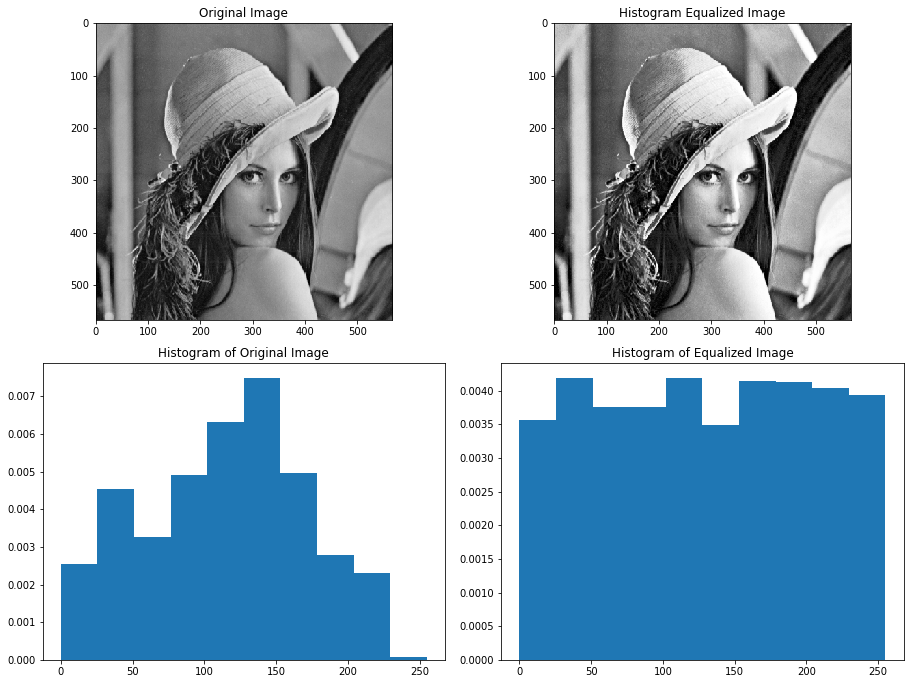

In [12]:
equalized_lena = equalize_hist(lena_img, 256)
fig, ax = plt.subplots(2, 2, figsize=(6.4 * 2, 4.8 * 2))
ax[0, 0].imshow(lena_img)
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(equalized_lena)
ax[0, 1].set_title("Histogram Equalized Image")
ax[1, 0].hist(lena_img.flatten(), density=True)
ax[1, 0].set_title("Histogram of Original Image")
ax[1, 1].hist(equalized_lena.flatten(), density=True)
ax[1, 1].set_title("Histogram of Equalized Image")
plt.tight_layout()

# 5. Adaptive Median Filter

### Function for the Adaptive Median Filter

In [13]:
# function for the adaptive median filter algorithm
def adaptiveMedianFilter(image, S_max):
    output_img = np.zeros(image.shape)
    
    # Stage A
    def stageA(currPos, window):
        x_min, x_max = max(0, currPos[0] - window // 2), min(image.shape[0], currPos[0] + window // 2)
        y_min, y_max = max(0, currPos[1] - window // 2), min(image.shape[1], currPos[1] + window // 2)
        temp_image = image[x_min:x_max + 1, y_min:y_max + 1]
        z_min = min(temp_image.flatten())
        z_max = max(temp_image.flatten())
        z_med = sorted(temp_image.flatten())[len(temp_image) // 2]
        
        A1 = z_med - z_min
        A2 = z_med - z_max
        
        if A1 > 0 and A2 < 0:
            return stageB(currPos, window)
        else:
            window += 1
            if window <= S_max:
                return stageA(currPos, window)
            else:
                return z_med
    
    # Stage B
    def stageB(currPos, window):
        temp_image = image[currPos[0]:currPos[0] + window, currPos[1]:currPos[1] + window]
        z_min = min(temp_image.flatten())
        z_max = max(temp_image.flatten())
        z_med = sorted(temp_image.flatten())[len(temp_image) // 2]
        z_xy = image[currPos[0], currPos[1]]
        
        B1 = z_xy - z_min
        B2 = z_xy = z_max
        
        if B1 > 0 and B2 < 0:
            return z_xy
        else:
            return z_med
    
    output_img = np.zeros(image.shape)
    for i in range(output_img.shape[0]):
        for j in range(output_img.shape[1]):
            output_img[i, j] = stageA((i, j), 1)
    
    return output_img

### Function for Salt and Pepper Noise

In [14]:
# function to add salt and pepper noise to an image
def salt_and_pepper_noise(image):
    max_int = 256
    noise_matrix = np.random.randint(max_int, size=image.shape)
    output = np.zeros(image.shape)
    for i in range(noise_matrix.shape[0]):
        for j in range(noise_matrix.shape[1]):
            if noise_matrix[i, j] == 0:
                output[i, j] = 0
            elif noise_matrix[i, j] == max_int - 1:
                output[i, j] = 255
            else:
                output[i, j] = image[i, j]
    
    return output

#### Adding Salt and Pepper noise and removing it with Adaptive Median Filter

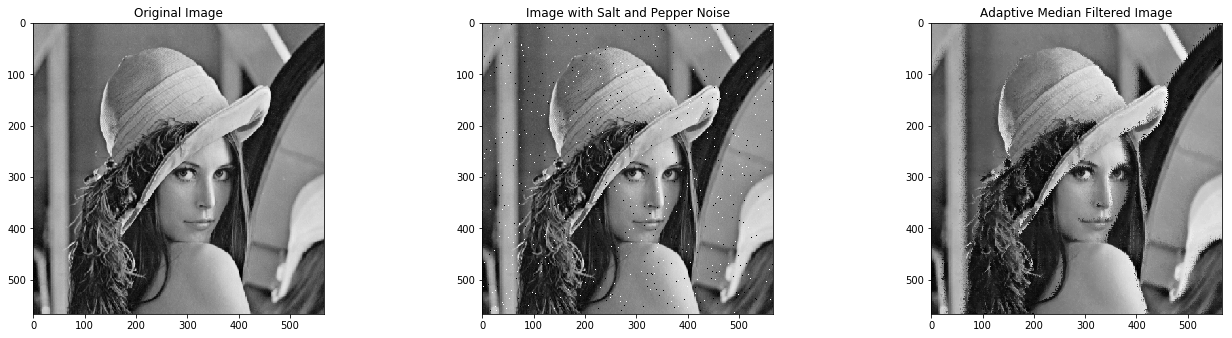

In [15]:
# adding salt and pepper noise and removing it with the adaptive median filter
noised = salt_and_pepper_noise(lena_img)
adaptive_median_filtered_lena = adaptiveMedianFilter(noised, 10)
fig, ax = plt.subplots(1, 3, figsize=(6.4 * 3, 4.8))
ax[0].imshow(lena_img)
ax[0].set_title("Original Image")
ax[1].imshow(noised)
ax[1].set_title("Image with Salt and Pepper Noise")
ax[2].imshow(adaptive_median_filtered_lena)
ax[2].set_title("Adaptive Median Filtered Image")
plt.tight_layout()

# 6. Gaussian Filter and Laplacian Filter

### Functions for Gaussian filter and Laplacian filter

In [16]:
# function to make a gaussian filter given a sigma
def gaussianFilter(sigma=1):
    filter_size = 5 * sigma + 1 if not sigma % 2 else 5 * sigma
    filter_ = np.zeros((filter_size, filter_size))
    for i in range(filter_size):
        for j in range(filter_size):
            part1 = -((i - filter_size // 2) ** 2 + (j - filter_size // 2) ** 2) / (2 * sigma ** 2)
            filter_[i, j] = np.exp(part1)
    
    return filter_


# function to make a laplacian filter given a sigma
def laplacianFilter(sigma=1):
    filter_size = 5 * sigma + 1 if not sigma % 2 else 5 * sigma
    filter_ = np.zeros((filter_size, filter_size))
    for i in range(filter_size):
        for j in range(filter_size):
            part1 = -((i - filter_size // 2) ** 2 + (j - filter_size // 2) ** 2) / (2 * sigma ** 2)
            filter_[i, j] = -(1 + part1) * np.exp(part1)# / (np.pi * (sigma ** 4))
    
    return filter_

#### Creating the filters

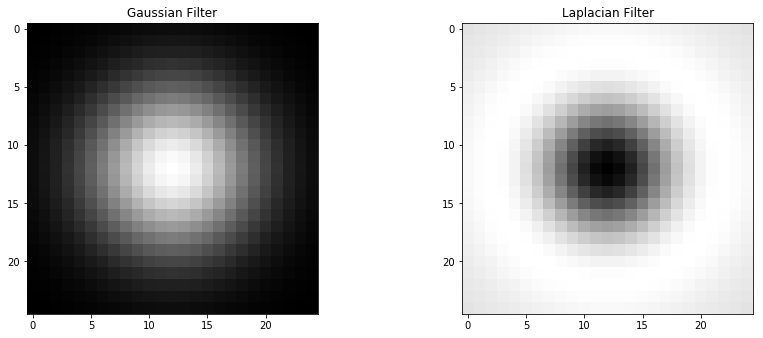

In [17]:
SIGMA = 5 # standard deviation for gaussian filter
gaussian_filter = gaussianFilter(SIGMA)
laplacian_filter = laplacianFilter(SIGMA)

fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].imshow(gaussian_filter)
ax[0].set_title("Gaussian Filter")
ax[1].imshow(laplacian_filter)
ax[1].set_title("Laplacian Filter")
plt.tight_layout()

#### Applying Gaussian and Laplacian Filters on the image

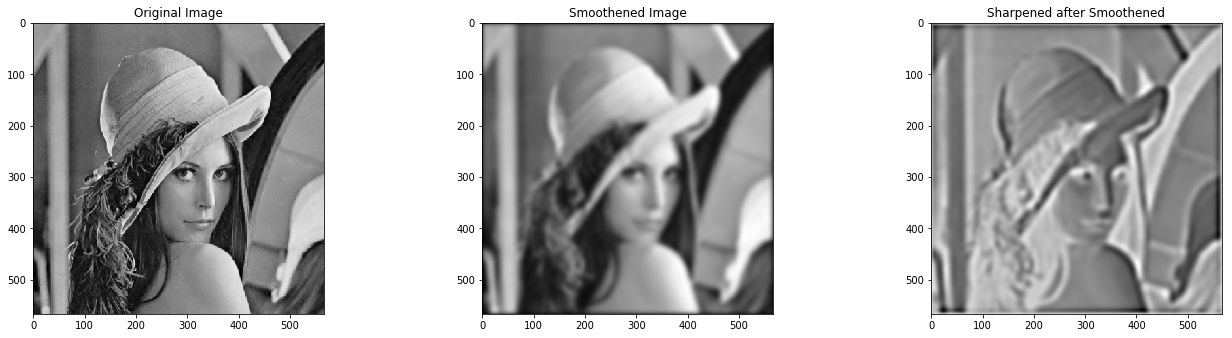

In [18]:
smoothened_lena = convolve(lena_img, gaussian_filter)
sharpened = convolve(smoothened_lena, laplacian_filter)
fig, ax = plt.subplots(1, 3, figsize=(6.4 * 3, 4.8))
ax[0].imshow(lena_img)
ax[0].set_title("Original Image")
ax[1].imshow(smoothened_lena)
ax[1].set_title("Smoothened Image")
ax[2].imshow(sharpened)
ax[2].set_title("Sharpened after Smoothened")
plt.tight_layout()